# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

## Question 5 - Part (A):

I use CIFAR dataset for this question. You can download here: [github.com/YoongiKim/CIFAR-10-images.git](https://github.com/YoongiKim/CIFAR-10-images.git)

### import libraries

In [81]:
import torch
from torch import nn, optim
import cv2
import matplotlib.pyplot as plt
import random
import os
import numpy as np
from skimage.util import img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

### check GPU availability

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### function for load images from personal dir

In [83]:
def read_img(dir, format):
    images = []
    for img in os.listdir(dir):
        if (img.endswith("." + format)):
            images.append(cv2.imread(os.path.join(dir, img)))
    return len(images), images

### load images

In [84]:
dir = "Dataset-Q5/"
_, images = read_img(dir, "jpg")
print("total images: ", len(images))

total images:  10


### plot full resolution images

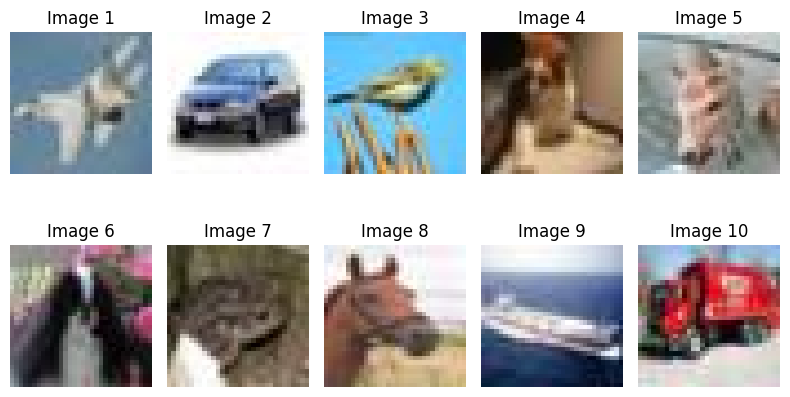

In [85]:
plt.figure(figsize=(8, 6))
for i, img in enumerate(images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Image {i + 1}")
    plt.tight_layout()
plt.show()

### half resulution of images

In [86]:
half_res_img = []
for img in images:
    half_res_img.append(cv2.resize(img, (img.shape[0] // 2, img.shape[1] // 2)))

### plot half resolution of images

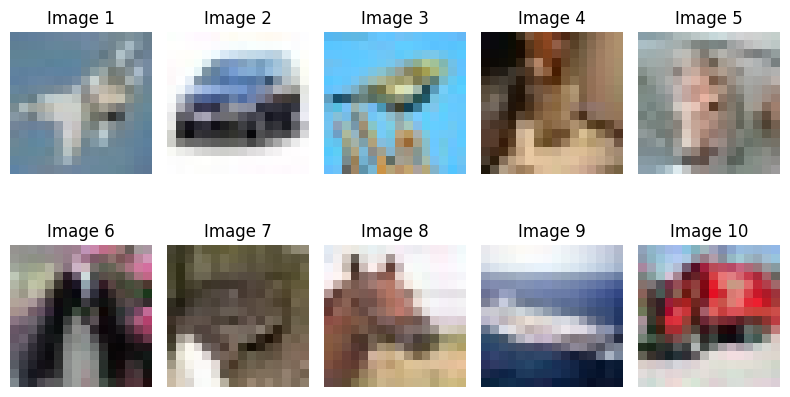

In [87]:
plt.figure(figsize=(8, 6))
for i, img in enumerate(half_res_img):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Image {i + 1}")
    plt.tight_layout()
plt.show()

### extract features

In [88]:
dataset = []

for img, half_res_img in zip(images, half_res_img):

    # conver img and half_res_img from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    half_res_img = cv2.cvtColor(half_res_img, cv2.COLOR_BGR2RGB)
    # shape of half_res_img is: (16, 16, 3)

    # pad the lower resolution image with zeros
    half_res_img = cv2.copyMakeBorder(half_res_img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    # shape of half_res_img is: (18, 18, 3)

    img_dataset = []
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Map the pixel to the lower resolution image
            i_half = i // 2
            j_half = j // 2
            
            # find the eight neighbors
            neighbors = []
            # if initial pixel is (i, j) in this loop find the neighbors
            # (i-1, j-1), (i-1, j), (i-1, j+1), and ...
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    # append each color channel separately
                    neighbors.extend(half_res_img[i_half + di + 1, j_half + dj + 1].tolist())
            
            # add the neighbors and the original pixel to the image dataset
            img_dataset.append((neighbors, img[i, j].tolist()))
    dataset.append(img_dataset)

# convert dataset to a PyTorch tensor
dataset = [[torch.tensor(data[0], dtype=torch.float, device=device),
             torch.tensor(data[1], dtype=torch.float, device=device)]
               for img_data in dataset for data in img_data]

### stack dataset into the features and labels

In [89]:
features = torch.stack([img_data[0] for img_data in dataset])
labels = torch.stack([img_data[1] for img_data in dataset])

print(f"Size of features tensor: {features.size()}")
print(f"Size of labels tensor: {labels.size()}")

Size of features tensor: torch.Size([10240, 27])
Size of labels tensor: torch.Size([10240, 3])


### split dataset into the train, test and validation sets
* training set: 7 image
* testing set: 2 image
* validation set: 1 image

In [90]:
train_dataset = dataset[:7*32*32]
test_dataset = dataset[7*32*32:9*32*32]
val_dataset = dataset[9*32*32:]

random.shuffle(train_dataset) # shuffle the training dataset

### stack features and labels separately for each dataset

In [91]:
train_features = torch.stack([data[0] for data in train_dataset])
train_labels = torch.stack([data[1] for data in train_dataset])
test_features = torch.stack([data[0] for data in test_dataset])
test_labels = torch.stack([data[1] for data in test_dataset])
val_features = torch.stack([data[0] for data in val_dataset])
val_labels = torch.stack([data[1] for data in val_dataset])

print(f"Size of training features tensor: {train_features.size()}")
print(f"Size of training labels tensor: {train_labels.size()}")
print()
print(f"Size of testing features tensor: {test_features.size()}")
print(f"Size of testing labels tensor: {test_labels.size()}")
print()
print(f"Size of validation features tensor: {val_features.size()}")
print(f"Size of validation labels tensor: {val_labels.size()}")

Size of training features tensor: torch.Size([7168, 27])
Size of training labels tensor: torch.Size([7168, 3])

Size of testing features tensor: torch.Size([2048, 27])
Size of testing labels tensor: torch.Size([2048, 3])

Size of validation features tensor: torch.Size([1024, 27])
Size of validation labels tensor: torch.Size([1024, 3])


### define network
* input lauer: 27 neurons
* hidden layer1: 64 neurons
* activation function of layer 1: ReLU
* hidden layer2: 128 neurons
* activation function of layer 1: ReLU
* output lauer: 3 neurons

In [92]:
class multi_layer_perceptron(nn.Module):
    def __init__(self):
        super(multi_layer_perceptron, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(27, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.layers(x)

### set network parameters

In [93]:
model = multi_layer_perceptron().to(device)

criterion = nn.MSELoss() # use mean squared error loss
optimizer = optim.Adam(model.parameters(), lr=0.001) # use adam optimizer

train_loss_values = []
train_accuracy_values = []
test_loss_values = []
test_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

EPOCH = 500

### function to calculate loss and accuracy

In [94]:
def calculate_loss_accuracy(dataset):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for i, data in enumerate(dataset, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_predictions += labels.size(0)
            correct_predictions += ((outputs - labels).abs() / labels.abs() < 0.1).sum().item()

            running_loss += loss.item()
    avg_loss = running_loss / len(dataset)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy


### train phase

In [ ]:
for epoch in range(EPOCH):
    model.train()
    running_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for i, data in enumerate(train_dataset, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_predictions += labels.size(0)
        correct_predictions += ((outputs - labels).abs() / labels.abs() < 0.1).sum().item()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataset)
    accuracy = correct_predictions / total_predictions
    train_loss_values.append(avg_loss)
    train_accuracy_values.append(accuracy)

    model.eval()
    test_loss, test_accuracy = calculate_loss_accuracy(test_dataset)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

    val_loss, val_accuracy = calculate_loss_accuracy(val_dataset)
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

    print ('Epoch [{}/{}] Train Loss: {:.4f} | Train Accuracy: {:.2f} | Test Loss: {:.4f} | Test Accuracy: {:.2f} | Validation Loss: {:.4f} | Validation Accuracy: {:.2f}  '.format(epoch+1,
            EPOCH, avg_loss, accuracy, test_loss, test_accuracy, val_loss, val_accuracy))

### plot loss and accuracy for each epoch

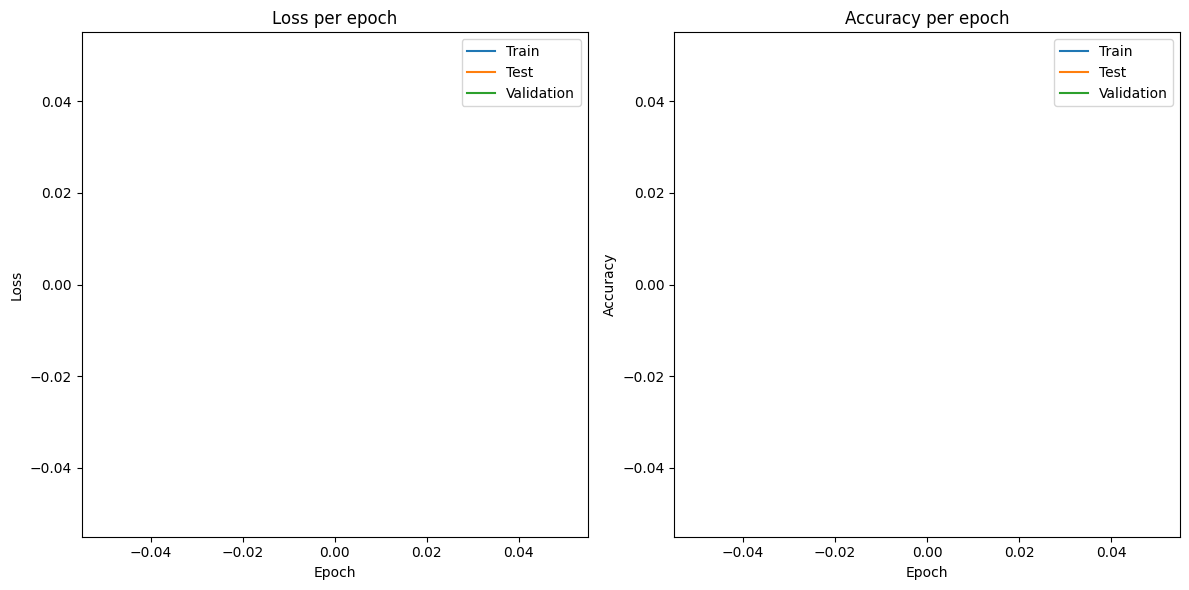

In [95]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train')
plt.plot(test_loss_values, label='Test')
plt.plot(val_loss_values, label='Validation')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values, label='Train')
plt.plot(test_accuracy_values, label='Test')
plt.plot(val_accuracy_values, label='Validation')
plt.title('Accuracy per epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## part C: reconstruction image

In [96]:
reconstructed_images = []

for half_res_img in half_res_img:
    half_res_img = cv2.cvtColor(half_res_img, cv2.COLOR_BGR2RGB)
    
    half_res_img = cv2.copyMakeBorder(half_res_img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    reconstructed_img = []
    
    for i in range(1, half_res_img.shape[0] - 1):
        for j in range(1, half_res_img.shape[1] - 1):
            neighbors = []
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    neighbors.extend(half_res_img[i + di, j + dj].tolist())
            
            neighbors = torch.tensor(neighbors, dtype=torch.float).to(device)
            output = model(neighbors)
            reconstructed_img.append(output.tolist())
    
    # reshape the reconstructed image to the original image size
    reconstructed_img = np.array(reconstructed_img, dtype=np.uint8).reshape((half_res_img.shape[0] - 2, half_res_img.shape[1] - 2, 3))
    reconstructed_images.append(reconstructed_img)

### Calculate SSIM and PSNR

In [97]:
ssim_values = []
psnr_values = []
for i, img in enumerate(reconstructed_images):
    if (i >= len(images)):
        print(f"Skipping index {i} because it's not in the original images list")
        continue
    img_true = img_as_float(images[i])  # Convert the original image to float
    img_test = img_as_float(img)  # Convert the reconstructed image to float

    # Resize img_test to match img_true if necessary
    if (img_true.shape != img_test.shape):
        img_test = cv2.resize(img_test, (img_true.shape[1], img_true.shape[0]))

    ssim_values.append(ssim(img_true, img_test, multichannel=True, win_size=3, data_range=1.0))  # Assuming images are normalized to [0, 1]
    psnr_values.append(psnr(img_true, img_test, data_range=1.0))  # Assuming images are normalized to [0, 1]

print(f"Average SSIM: {np.mean(ssim_values)}")
print(f"Average PSNR: {np.mean(psnr_values)}")

Skipping index 10 because it's not in the original images list
Skipping index 11 because it's not in the original images list
Skipping index 12 because it's not in the original images list
Skipping index 13 because it's not in the original images list
Skipping index 14 because it's not in the original images list
Skipping index 15 because it's not in the original images list
Skipping index 16 because it's not in the original images list
Skipping index 17 because it's not in the original images list
Average SSIM: -0.0026151837350104263
Average PSNR: 5.509358060492589


### plot results

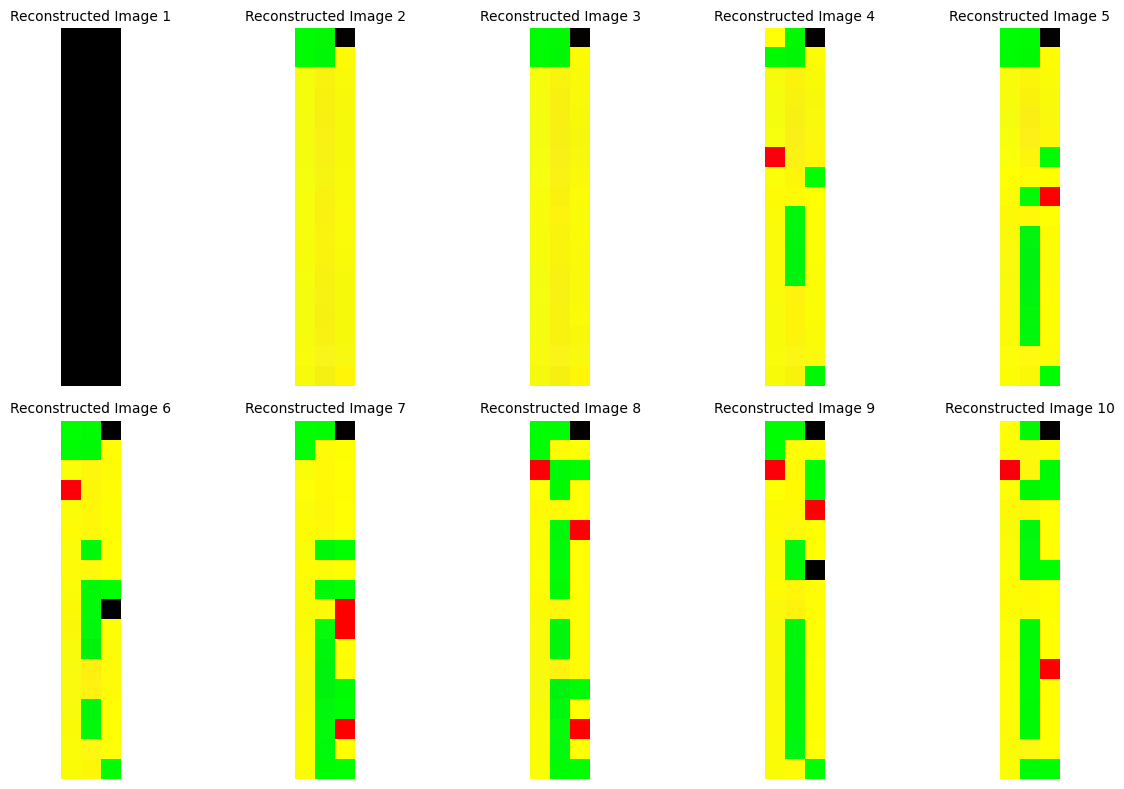

In [98]:
plt.figure(figsize=(15, 8))
for i, img in enumerate(reconstructed_images[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Reconstructed Image {i + 1}", size=10)
    plt.tight_layout()
plt.show()